In [2]:
# === 1. IMPORT LIBRARIES ===
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

# === 2. PATH TO CSV AND IMAGES ===
CSV_PATH = r"NeoJaundice\chd_jaundice_published_2.csv"
IMG_DIR = r"NeoJaundice\images"

# === 3. LOAD THE CSV ===
df = pd.read_csv(CSV_PATH)

# Preview
print("Dataset preview:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Dataset preview:
   patient_id   image_idx gender  gestational_age  age(day)  weight  \
0           3  0003-1.jpg      F               40       5.2    3280   
1           3  0003-2.jpg      F               40       5.2    3280   
2           3  0003-3.jpg      F               40       5.2    3280   
3          35  0035-1.jpg      M               39       8.7    3760   
4          35  0035-2.jpg      M               39       8.7    3760   

   blood(mg/dL)  Treatment  
0           3.9          0  
1           3.9          0  
2           3.9          0  
3          12.2          0  
4          12.2          0  

Missing values in each column:
patient_id         0
image_idx          0
gender             0
gestational_age    0
age(day)           6
weight             0
blood(mg/dL)       0
Treatment          0
dtype: int64


In [3]:
# === 4. LOAD IMAGES AND MATCH WITH BILIRUBIN ===
image_data = []
labels = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row['image_idx'])  # Ensure CSV has 'ImageName' or similar column
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))  # Resize for consistency
        image_data.append(img)
        labels.append(row['blood(mg/dL)'])   # Make sure this column exists in CSV

image_data = np.array(image_data)
labels = np.array(labels)

print(f"\nLoaded {len(image_data)} images.")



Loaded 2235 images.


In [4]:
# === 5. COLOR CORRECTION FUNCTION ===
def apply_color_correction(image, clip_limit=2.0, tile_grid_size=(8, 8), gamma=1.0):
    """
    Enhanced color correction using CLAHE in LAB space + Gamma correction.
    
    Args:
        image (np.ndarray): Input BGR image.
        clip_limit (float): CLAHE clipping limit for contrast.
        tile_grid_size (tuple): Grid size for CLAHE.
        gamma (float): Gamma correction value (1.0 = no correction).
    
    Returns:
        np.ndarray: Color-corrected BGR image.
    """
    # Convert to LAB for luminance correction
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to L channel (better than simple equalization)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l_corrected = clahe.apply(l)
    
    # Gamma correction on L channel (optional)
    if gamma != 1.0:
        l_corrected = np.power(l_corrected / 255.0, gamma) * 255.0
        l_corrected = l_corrected.astype(np.uint8)
    
    # Merge channels and convert back to BGR
    lab_corrected = cv2.merge((l_corrected, a, b))
    final_corrected = cv2.cvtColor(lab_corrected, cv2.COLOR_LAB2BGR)
    
    return final_corrected

# === 6. APPLY CORRECTION TO ALL IMAGES ===
corrected_images = np.array([apply_color_correction(img) for img in image_data])

print(f"Color correction applied to {len(corrected_images)} images.")


Color correction applied to 2235 images.


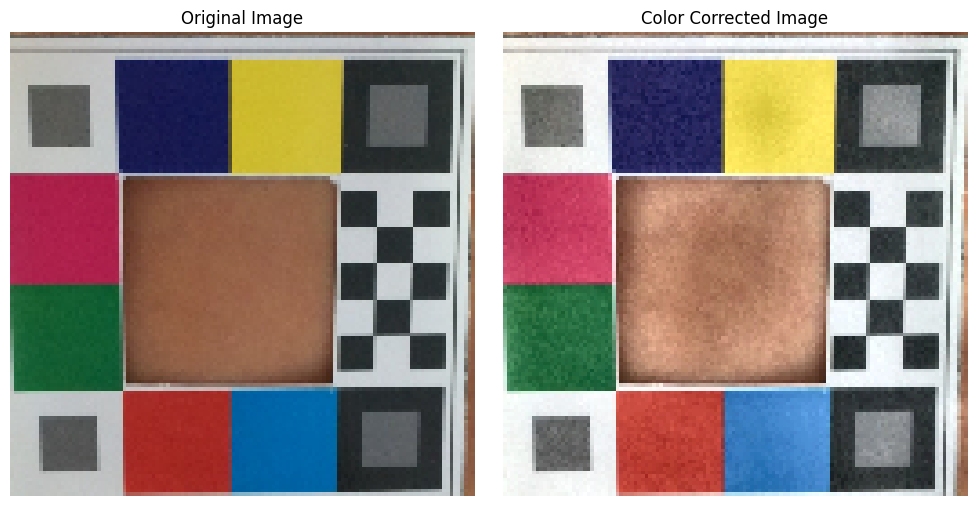

In [5]:
# === 7. PLOT ORIGINAL VS CORRECTED SAMPLE IMAGE ===
sample_idx = 146  # Any image index

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_data[sample_idx], cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(corrected_images[sample_idx], cv2.COLOR_BGR2RGB))
plt.title("Color Corrected Image")
plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
# === 8. CROP CENTRAL REGION FUNCTION ===
def crop_and_resize(image, central_fraction=0.4, target_size=(128, 128)):
    """
    Crop the central region (e.g., 40%) and resize back to original dimensions.
    
    Args:
        image (np.ndarray): Input image (H, W, C).
        central_fraction (float): Fraction of the center to crop (e.g., 0.4 for 40%).
        target_size (tuple): Desired output size (height, width).
        
    Returns:
        np.ndarray: Cropped and resized image.
    """
    h, w = image.shape[:2]
    
    # Step 1: Crop the central region (e.g., 40%)
    crop_h = int(h * central_fraction)
    crop_w = int(w * central_fraction)
    start_h = (h - crop_h) // 2
    start_w = (w - crop_w) // 2
    cropped = image[start_h:start_h + crop_h, start_w:start_w + crop_w]
    
    # Step 2: Resize back to original dimensions (e.g., 128x128)
    resized = cv2.resize(cropped, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
    
    return resized

# === 9. OPTIONAL: SKIN MASK FILTER IN HSV RANGE ===
def extract_skin_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 30, 60], dtype=np.uint8)
    upper = np.array([20, 150, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower, upper)
    skin = cv2.bitwise_and(image, image, mask=mask)
    return skin

# === 10. APPLY CROP AND SKIN FILTER TO ALL CORRECTED IMAGES ===
segmented_images = []
for img in corrected_images:
    central_crop = crop_and_resize(img, central_fraction=0.40)
    #skin = extract_skin_mask(central_crop)
    segmented_images.append(central_crop)

segmented_images = np.array(segmented_images)

print(f"Segmented {len(segmented_images)} central skin regions.")


Segmented 2235 central skin regions.


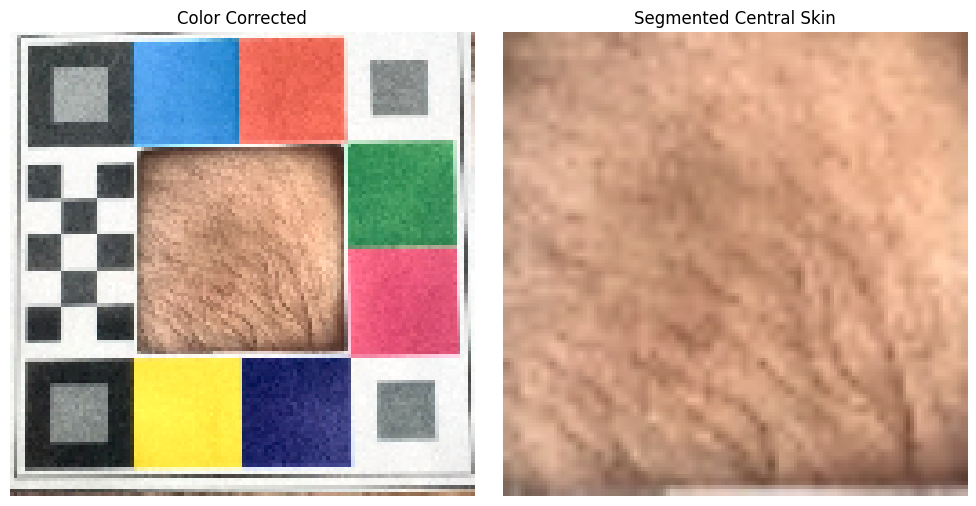

In [7]:
# === 11. PLOT BEFORE VS CROP+SKIN ===
sample_idx = 531

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(corrected_images[sample_idx], cv2.COLOR_BGR2RGB))
plt.title("Color Corrected")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented_images[sample_idx], cv2.COLOR_BGR2RGB))
plt.title("Segmented Central Skin")
plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
def apply_clahe(img):
    img_uint8 = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)


In [9]:
# === 2. Convert Labels (Bilirubin) to NumPy Array ===
targets = np.array(labels).astype(np.float32)


In [10]:
enhanced_images = np.array([apply_clahe(img) for img in segmented_images])


In [11]:
def rgb_hsv_stack(img):
    rgb = img.astype(np.uint8)
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    stacked = np.concatenate((rgb, hsv), axis=-1)  # shape: (128, 128, 6)
    return stacked

# Apply to all resized images
stacked_images = np.array([rgb_hsv_stack(img * 255) for img in enhanced_images])  # undo normalization first

# Normalize stacked image (0–255 → 0–1)
stacked_images = stacked_images.astype(np.float32) / 255.0

print("Stacked shape:", stacked_images.shape)  # should be (2235, 128, 128, 6)


Stacked shape: (2235, 128, 128, 6)


In [12]:
def rgb_lab_stack(images):
    stacked_images = []
    for img in images:
        lab = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
        lab = lab.astype(np.float32) / 255.0
        stacked = np.concatenate([img, lab], axis=-1)  # shape: (128, 128, 6)
        stacked_images.append(stacked)
    return np.array(stacked_images)

X_rgb_lab = rgb_lab_stack(enhanced_images)


In [13]:
def convert_and_stack_all_spaces(images):
    combined = []
    for img in images:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        # Normalize all to [0, 1]
        img_rgb = img_rgb / 255.0
        img_hsv = img_hsv / 255.0
        img_lab = img_lab / 255.0

        # Stack all channels: shape becomes (128, 128, 9)
        stacked = np.concatenate([img_rgb, img_hsv, img_lab], axis=-1)
        combined.append(stacked)
    
    return np.array(combined)


In [14]:
combined_images = convert_and_stack_all_spaces(segmented_images)  # `image_data` = segmented skin patches
print("Combined shape:", combined_images.shape)


Combined shape: (2235, 128, 128, 9)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(combined_images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# No augmentation for validation/test
val_datagen = ImageDataGenerator()

# Apply it to training and validation sets
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


c:\Users\Anshumaan Karna\Desktop\Neonatal Jaundice Prediction\testenv\lib\site-packages\keras\src\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1564, 128, 128, 9) (9 channels).
  warnings.warn(
c:\Users\Anshumaan Karna\Desktop\Neonatal Jaundice Prediction\testenv\lib\site-packages\keras\src\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (335, 128, 128, 9) (9 channels).
  warnings.warn(


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

model = Sequential([
    Input(shape=(128, 128, 9)),  # <- update this!
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


history = model.fit(
    X_train,
    y_train,
    epochs=25,
    validation_data=(X_val,y_val)
    
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      2624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 57600)             0         
                                                                 
 dense_3 (Dense)             (None, 32)               

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# === 1. Predict ===
y_pred = model.predict(X_test).flatten()
y_true = y_test.flatten()

# === 2. Compute Metrics ===
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# === 3. Print Results ===
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")


11/11 [==============================] - 0s 38ms/step
MAE: 3.196
RMSE: 3.932
R² Score: 0.458


11/11 [==============================] - 0s 31ms/step


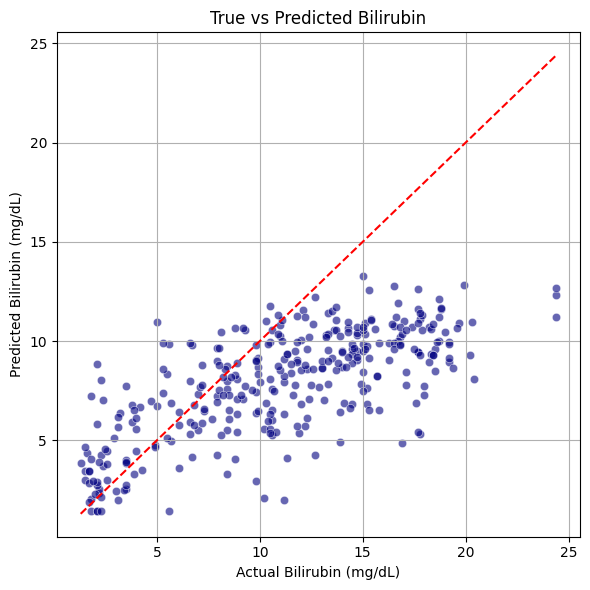

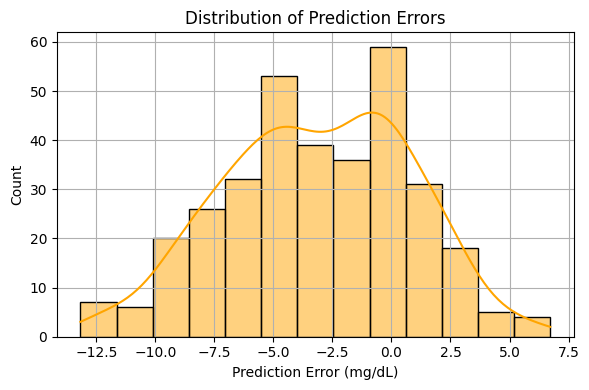

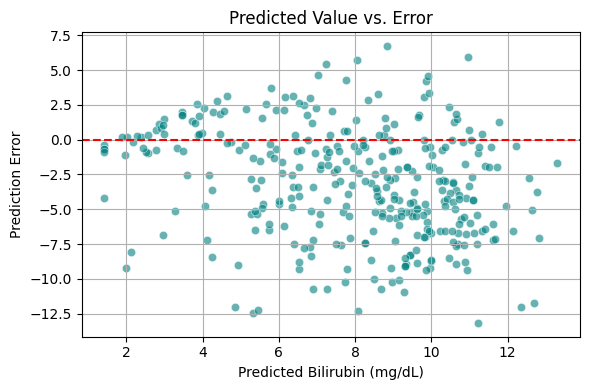

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Ensure predictions and ground truths are flattened
y_pred = model.predict(X_test).flatten()
y_true = y_test.flatten()
errors = y_pred - y_true

# === 1. True vs Predicted ===
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=y_pred, color='navy', alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("Actual Bilirubin (mg/dL)")
plt.ylabel("Predicted Bilirubin (mg/dL)")
plt.title("True vs Predicted Bilirubin")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Residual Error Distribution ===
plt.figure(figsize=(6, 4))
sns.histplot(errors, kde=True, color='orange')
plt.xlabel("Prediction Error (mg/dL)")
plt.title("Distribution of Prediction Errors")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. Predicted vs Error ===
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=errors, color='teal', alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted Bilirubin (mg/dL)")
plt.ylabel("Prediction Error")
plt.title("Predicted Value vs. Error")
plt.grid(True)
plt.tight_layout()
plt.show()
